In [42]:
import sys
sys.path.append('..')

import utils, selex_dca, indep_sites
import adabmDCA
import selex_distribution, energy_models, tree, data_loading, training, callback, sampling

import torch
from utils import one_hot
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

In [43]:
import importlib
importlib.reload(utils)
importlib.reload(selex_distribution)
importlib.reload(energy_models)
importlib.reload(sampling)
importlib.reload(training)

<module 'training' from '/Users/scrotti/Aptamer2025py/training.py'>

In [7]:
experiment_id = "Dop8V030"
round_ids = ["ARN", "R01", "R01CS", "R02N"]

device = torch.device("cpu")
dtype = torch.float64

In [ ]:
sequences = []
for round_id in round_ids:
    s = utils.sequences_from_file(experiment_id, round_id, device)
    sequences.append(s)
    print(f"finished {round_id}")

In [9]:
sequences_oh = [one_hot(seq).to(dtype=dtype, device=device) for seq in sequences]

In [ ]:
# del sequences

In [11]:
total_reads = torch.Tensor([s.shape[0] for s in sequences_oh]).to(device)
fi0, _, _ = utils.frequences_from_sequences_oh(sequences_oh[0])

In [51]:
tr = tree.Tree()
tr.add_node(-1, name = "R01")
tr.add_node(-1, name = "R01CS")
tr.add_node(0, name = "R02N")

mode_names = ["target", "bead"]

selected_modes = torch.BoolTensor(
    [[1, 1],[0, 1], [1, 1]]
).to(device)

In [52]:
L, q = sequences_oh[0][0].shape

k = torch.zeros(L, q, dtype=dtype, device=device)
# k = torch.log(fi0)
h_target = torch.zeros(L, q, dtype=dtype, device=device)
J_target = torch.zeros(L, q, L, q, dtype=dtype, device=device)
h_bead = torch.zeros(L, q, dtype=dtype, device=device)
J_bead = torch.zeros(L, q, L, q, dtype=dtype, device=device)

Ns0 = energy_models.IndepSites(k)
potts_target = energy_models.Potts(J_target, h_target)
potts_bead = energy_models.Potts(J_bead, h_bead)

ps = selex_distribution.MultiModeDistribution(potts_target, potts_bead, normalized=True)
model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes)

In [53]:
batch_size = 10**6
data_loaders = [data_loading.SelexRoundDataLoader(seq_oh, batch_size=batch_size) for seq_oh in sequences_oh]
n_rounds = len(data_loaders) 

In [54]:
n_chains = 10**4

chains = training.init_chains(n_rounds, n_chains, L, q, device, dtype)
log_weights = torch.zeros(n_rounds, n_chains, device=device, dtype=dtype)

In [55]:
callbacks = [callback.ConvergenceMetricsCallback(), callback.PearsonCovarianceCallback()]

In [56]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [57]:
n_sweeps = 10
lr = 0.01
target_pearson = 1
max_epochs = 20

%lprun -f training.train training.train(model, data_loaders, total_reads, chains, n_sweeps, lr, max_epochs, target_pearson, callbacks=callbacks)

 0.00%[                               ] Epoch: 0/20 [00:00, ?it/s]

Timer unit: 1e-09 s

Total time: 882.467 s
File: /Users/scrotti/Aptamer2025py/training.py
Function: train at line 73

Line #      Hits         Time  Per Hit   % Time  Line Contents
    73                                           def train(
    74                                               model: selex_distribution.MultiRoundDistribution,
    75                                               data_loaders,
    76                                               total_reads,
    77                                               chains: torch.Tensor,
    78                                               n_sweeps: int,
    79                                               lr: float,    
    80                                               max_epochs: int,
    81                                               target_pearson = 0.999,
    82                                               thresh_slope = 1e-2,
    83                                               l2reg: float = 0.0,
    84            

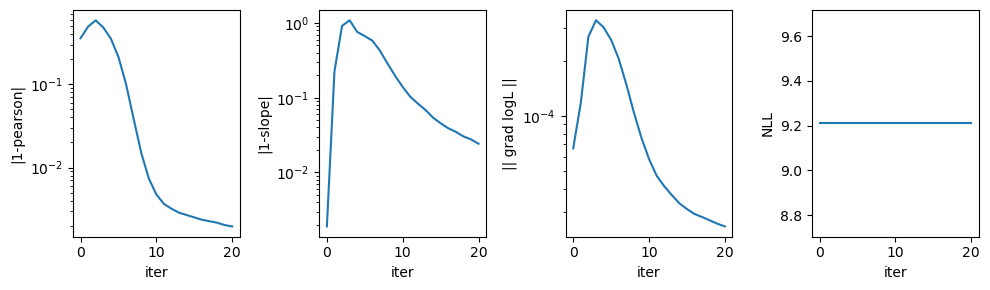

In [58]:
callbacks[0].plot();

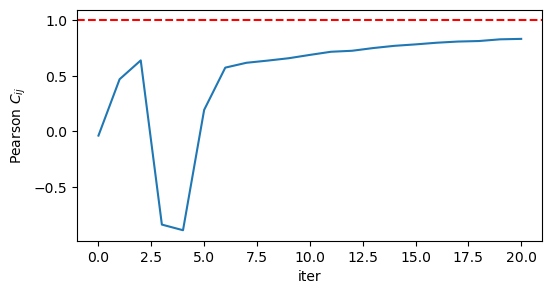

In [59]:
fig, ax = callbacks[1].plot()
ax.axhline(1, color='r', linestyle='--')

<IPython.core.display.Latex object>

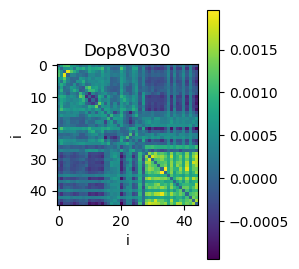

In [60]:
from IPython.display import display, Latex

potts_zerosum = potts_target.set_zerosum_gauge()

pl, ax = plt.subplots(figsize=(3,3))
F = selex_dca.get_contact_map(potts_zerosum.J.detach())
im = ax.imshow(F)
ax.set_xlabel("i"); ax.set_ylabel("i")
ax.set_title(experiment_id)
plt.colorbar(im)
plt.tight_layout()
# im.set_clim(-0.0015, 0.0030)
display(Latex("$F_{ij}=\\sqrt {\\sum_{ab}(J_{ij}^{ab})^2}$"))

<IPython.core.display.Latex object>

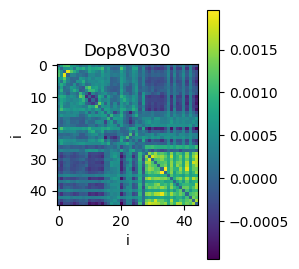

In [61]:
from IPython.display import display, Latex

potts_zerosum = potts_bead.set_zerosum_gauge()

pl, ax = plt.subplots(figsize=(3,3))
F = selex_dca.get_contact_map(potts_zerosum.J.detach())
im = ax.imshow(F)
ax.set_xlabel("i"); ax.set_ylabel("i")
ax.set_title(experiment_id)
plt.colorbar(im)
plt.tight_layout()
# im.set_clim(-0.0015, 0.0030)
display(Latex("$F_{ij}=\\sqrt {\\sum_{ab}(J_{ij}^{ab})^2}$"))

In [62]:
potts_bead.J

Parameter containing:
tensor([[[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-6.5400e-04,  1.7854e-03,  6.7212e-04,  1.6097e-02],
          [-3.8059e-04, -5.5449e-04,  1.8041e-02,  7.9544e-04],
          ...,
          [-1.6678e-03, -8.9376e-04, -1.4023e-03,  2.1865e-02],
          [-1.0393e-03,  1.9374e-02, -9.2673e-04,  4.9331e-04],
          [ 3.6452e-05, -6.9324e-04,  1.8287e-02,  2.7117e-04]],

         [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-1.2422e-03, -1.3161e-03, -1.1621e-03, -6.9308e-04],
          [-1.2855e-03, -1.3094e-03, -6.0621e-04, -1.2125e-03],
          ...,
          [-1.4506e-03, -1.3526e-03, -1.4471e-03, -1.6331e-04],
          [-1.3733e-03, -3.3550e-04, -1.4013e-03, -1.3035e-03],
          [-1.3043e-03, -1.3611e-03, -4.6789e-04, -1.2802e-03]],

         [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-1.0477e-03, -1.1564e-03, -1.2307e-03,  1.3486e-03],
          [-1.2354e-03, -1.0128e-03,  1.1949e-03

In [63]:
potts_target.J

Parameter containing:
tensor([[[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 6.5400e-04, -1.7854e-03, -6.7212e-04, -1.6097e-02],
          [ 3.8059e-04,  5.5449e-04, -1.8041e-02, -7.9544e-04],
          ...,
          [ 1.6678e-03,  8.9376e-04,  1.4023e-03, -2.1865e-02],
          [ 1.0393e-03, -1.9374e-02,  9.2673e-04, -4.9331e-04],
          [-3.6452e-05,  6.9324e-04, -1.8287e-02, -2.7117e-04]],

         [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 1.2422e-03,  1.3161e-03,  1.1621e-03,  6.9308e-04],
          [ 1.2855e-03,  1.3094e-03,  6.0621e-04,  1.2125e-03],
          ...,
          [ 1.4506e-03,  1.3526e-03,  1.4471e-03,  1.6331e-04],
          [ 1.3733e-03,  3.3550e-04,  1.4013e-03,  1.3035e-03],
          [ 1.3043e-03,  1.3611e-03,  4.6789e-04,  1.2802e-03]],

         [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 1.0477e-03,  1.1564e-03,  1.2307e-03, -1.3486e-03],
          [ 1.2354e-03,  1.0128e-03, -1.1949e-03